<a href="https://colab.research.google.com/github/rithikkulkarni/Video-Virality/blob/main/notebooks/classification_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🚀 YouTube Video Virality – Binary Classification
This notebook builds classification models to predict whether a YouTube video will go **viral (1)** or **not viral (0)** using image and text-based features.


In [33]:
import pandas as pd

url = "https://raw.githubusercontent.com/rithikkulkarni/Video-Virality/refs/heads/main/data/video_details_v8.csv"
df = pd.read_csv('/content/video_details_v8.csv')
df.head()
df.columns

Index(['channel_id', 'description', 'tags', 'title', 'avg_red', 'avg_green',
       'avg_blue', 'brightness', 'contrast', 'video_id', 'viewCount',
       'likeCount', 'commentCount', 'title_sentiment', 'title_subjectivity',
       'has_question', 'has_exclamation', 'starts_with_keyword',
       'title_length', 'word_count', 'punctuation_count',
       'uppercase_word_count', 'percent_letters_uppercase', 'has_numbers',
       'clickbait_score', 'viral', 'description_length',
       'description_sentiment', 'description_has_keywords', 'tag_count',
       'tag_sentiment', 'num_unique_tags', 'title_embedding',
       'embedding_distance_to_known_viral', 'title_readability',
       'title_embedding_distance_to_viral', 'dominant_color_hue',
       'thumbnail_edge_density', 'log_viewCount', 'log_likeCount',
       'log_commentCount'],
      dtype='object')

In [34]:
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import roc_auc_score, precision_score, recall_score, roc_curve
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import numpy as np

X = df.drop(columns=["video_id", "title", "channel_id",
    "viewCount", "likeCount", "commentCount", "viral", "description", "tags", "title_embedding"
    ,"log_viewCount", "log_likeCount", "log_commentCount", "embedding_distance_to_known_viral", "title_embedding_distance_to_viral", "num_unique_tags"
                     ])
y = df['viral']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [35]:
X.columns

Index(['avg_red', 'avg_green', 'avg_blue', 'brightness', 'contrast',
       'title_sentiment', 'title_subjectivity', 'has_question',
       'has_exclamation', 'starts_with_keyword', 'title_length', 'word_count',
       'punctuation_count', 'uppercase_word_count',
       'percent_letters_uppercase', 'has_numbers', 'clickbait_score',
       'description_length', 'description_sentiment',
       'description_has_keywords', 'tag_count', 'tag_sentiment',
       'title_readability', 'dominant_color_hue', 'thumbnail_edge_density'],
      dtype='object')

In [36]:
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

models = {
    "XGBoost": ImbPipeline([
        ("smote", SMOTE(random_state=42)),
        ("clf", XGBClassifier(
            scale_pos_weight=(sum(y == 0) / sum(y == 1)),
            use_label_encoder=False,
            eval_metric="logloss",
            random_state=42))
    ]),
    "SMOTE + Random Forest": ImbPipeline([
        ("smote", SMOTE(random_state=42)),
        ("clf", RandomForestClassifier(n_estimators=100, random_state=42))
    ])
}


🔍 XGBoost – 10-Fold Cross-Validation


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:45:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:45:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:45:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:45:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:45:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

Precision (threshold=0.3): 0.168
Recall (threshold=0.3): 0.585
ROC AUC: 0.731

Classification Report (threshold={new_threshold}):
              precision    recall  f1-score   support

           0      0.952     0.741     0.834     14305
           1      0.168     0.585     0.261      1278

    accuracy                          0.728     15583
   macro avg      0.560     0.663     0.547     15583
weighted avg      0.888     0.728     0.787     15583



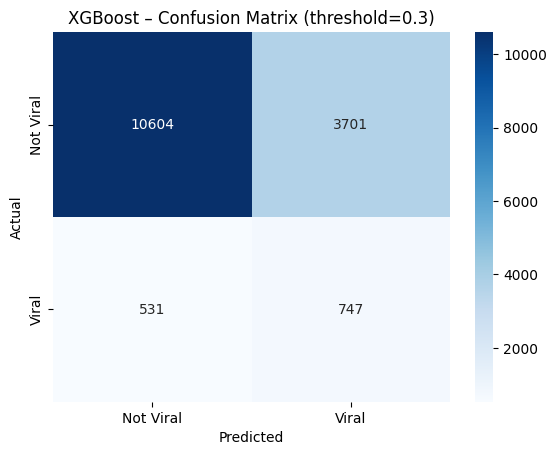

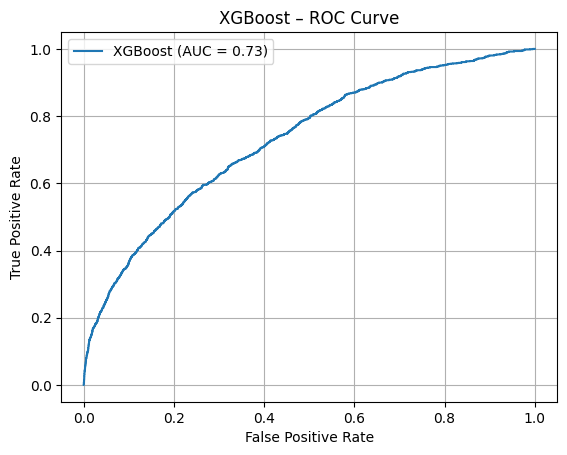

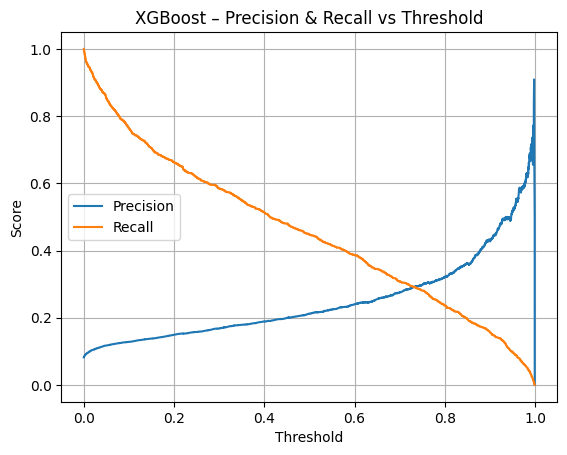


🔍 SMOTE + Random Forest – 10-Fold Cross-Validation
Precision (threshold=0.3): 0.224
Recall (threshold=0.3): 0.508
ROC AUC: 0.773

Classification Report (threshold={new_threshold}):
              precision    recall  f1-score   support

           0      0.950     0.843     0.893     14305
           1      0.224     0.508     0.311      1278

    accuracy                          0.815     15583
   macro avg      0.587     0.675     0.602     15583
weighted avg      0.891     0.815     0.845     15583



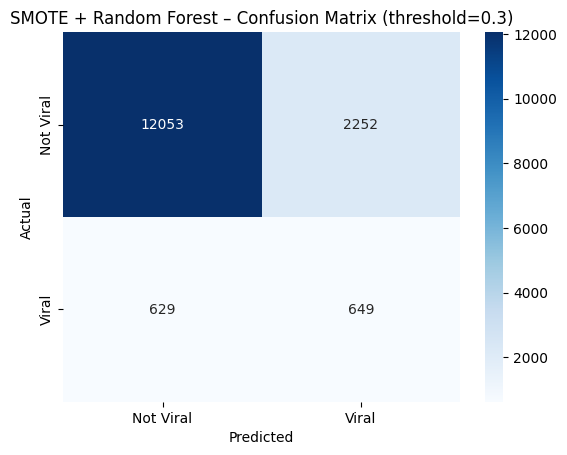

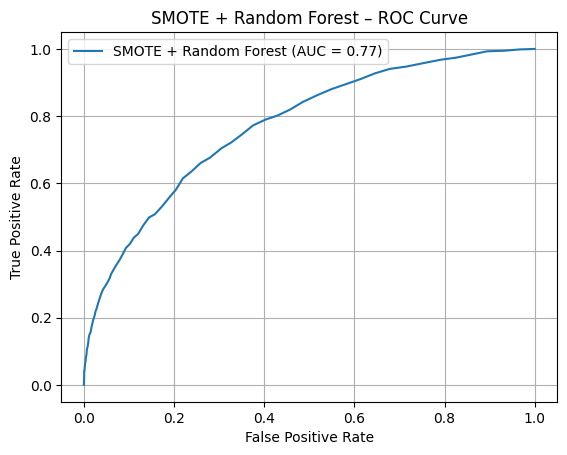

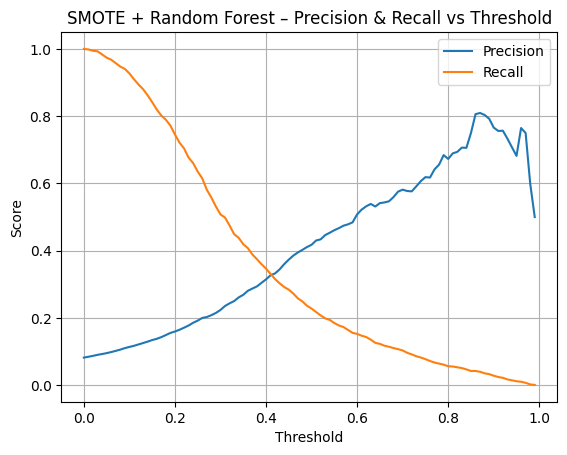

In [37]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix

for name, pipeline in models.items():
    print(f"\n🔍 {name} – 10-Fold Cross-Validation")

    # Collect predictions and probabilities via CV
    probs = cross_val_predict(pipeline, X_scaled, y, cv=cv, method='predict_proba')[:, 1]

    # Define your desired threshold (e.g., 0.3 instead of 0.5)
    new_threshold = 0.3

    # Apply the new threshold to get predictions
    preds_at_threshold = (probs >= new_threshold).astype(int)

    # Evaluation metrics using the new predictions
    precision = precision_score(y, preds_at_threshold)
    recall = recall_score(y, preds_at_threshold)
    roc_auc = roc_auc_score(y, probs) # ROC AUC is not affected by threshold

    print(f"Precision (threshold={new_threshold}): {precision:.3f}")
    print(f"Recall (threshold={new_threshold}): {recall:.3f}")
    print(f"ROC AUC: {roc_auc:.3f}")
    print("\nClassification Report (threshold={new_threshold}):")
    print(classification_report(y, preds_at_threshold, digits=3))

    # Confusion Matrix
    cm = confusion_matrix(y, preds_at_threshold)
    import seaborn as sns
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Viral", "Viral"], yticklabels=["Not Viral", "Viral"])
    plt.title(f"{name} – Confusion Matrix (threshold={new_threshold})")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # ROC Curve (still use original probabilities)
    fpr, tpr, _ = roc_curve(y, probs)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")
    plt.title(f"{name} – ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.grid()
    plt.show()

    # Precision-Recall vs Threshold Plot (still use original probabilities)
    from sklearn.metrics import precision_recall_curve

    prec, rec, thresholds = precision_recall_curve(y, probs)
    plt.figure()
    plt.plot(thresholds, prec[:-1], label='Precision')
    plt.plot(thresholds, rec[:-1], label='Recall')
    plt.xlabel('Threshold')
    plt.ylabel('Score')
    plt.title(f'{name} – Precision & Recall vs Threshold')
    plt.legend()
    plt.grid()
    plt.show()